In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cPickle
import matplotlib.pyplot as plt
import os

load_data = 1

In [2]:
from scipy.interpolate import pchip_interpolate

def jump_stitcher_anyMetric(incorrectVar, plot_flag):
    incorrectVar_diff = np.diff(incorrectVar)
    if incorrectVar_diff.size:
        diff_cutoff = np.percentile(incorrectVar_diff, 99)*10;

        out_of_bound_max_cutoff = np.percentile(incorrectVar,99)+(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2
        out_of_bound_min_cutoff = np.percentile(incorrectVar,1)-(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2

        out_of_bound_index = np.where((incorrectVar>out_of_bound_max_cutoff) | (incorrectVar<out_of_bound_min_cutoff))
        out_of_bound_index = np.asarray(out_of_bound_index).flatten()
        discontinuity_index = np.array([-1])

        for i in range(0, len(incorrectVar_diff)):
            if np.abs(incorrectVar_diff[i]) > diff_cutoff:
                discontinuity_index = [discontinuity_index, (i-1), i, (i+1)]

        discontinuity_index = np.unique(discontinuity_index[discontinuity_index > 0])

        incorrectVar_nan = incorrectVar
        incorrectVar_nan[np.union1d(out_of_bound_index,discontinuity_index)] = np.nan
        correctedVar = pchip_interpolate(np.arange(0, len(incorrectVar_nan)), 
                                         incorrectVar_nan, np.arange(0,len(incorrectVar_nan)))

        if plot_flag == 1:
            fig = plt.figure(figsize=(15, 8))
            plt.plot(np.arange(0, len(incorrectVar_nan[1000:1300])), incorrectVar_nan[1000:1300], color='k')
            plt.plot(np.arange(0, len(correctedVar[1000:1300])), 2+correctedVar[1000:1300], 'r')
            plt.show()
    else:
        correctedVar = incorrectVar

    return correctedVar

def calculateTailSpeed(tailposition, tf, history):
    tailSpeed = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    tailDisplacement = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    x = (tailposition[history:, 0] - tailposition[:-history, 0])**2
    y = (tailposition[history:, 1] - tailposition[:-history, 1])**2
    tailDisplacement[history:] = np.sqrt(x + y).copy()
    tailDisplacement = jump_stitcher_anyMetric(tailDisplacement, 0)
    tailSpeed[history:] = tailDisplacement[history:]/np.asarray(history*tf, dtype=np.float)
    tailSpeed = jump_stitcher_anyMetric(tailSpeed, 0)
    return tailSpeed

In [3]:
if load_data > 0:
    data_dir = '../../../Data/20180323_Cha_CsChrimson_Tail_DoseResponse_600micron/XML'
    kin_data_all = pd.read_csv(os.path.join(data_dir, 'kinData_xml.dat'), sep='\t', low_memory=False)

In [4]:
kin_data_all.columns

Index([u'num', u'timeIndex', u'allocentricHeadAngleSpeed', u'behaviorMode',
       u'bodyAngleSpeed', u'centroidSpeed', u'derivedMaxLength',
       u'headAngleSpeed', u'headSpeed', u'jumpFramesSkipped', u'midpointSpeed',
       u'percentageOfMaxLength', u'smoothedAllocentricHeadAngle',
       u'smoothedAllocentricHeadAngleSpeed', u'smoothedBodyAngleSpeed',
       u'smoothedHeadAngleSpeed', u'smoothedTailSpeedDotBodyAngle',
       u'tailSpeed', u'tailSpeedDotBodyAngle', u'timeBackingUp',
       u'timeSinceLastBehaviorModeChange', u'timeStopped', u'captureTime',
       u'headToBodyAngle', u'length', u'tailBearing', u'mid_x', u'mid_y',
       u'centroid_x', u'centroid_y', u'head_x', u'head_y', u'tail_x',
       u'tail_y', u'color', u'height', u'rotation', u'width', u'x', u'y',
       u'intensity'],
      dtype='object')

In [5]:
start_frame = 250
end_frame = 33000
all_tail_speed = kin_data_all.loc[:,['tailSpeed', 'num', 'timeIndex']].pivot(index='num', columns='timeIndex').as_matrix()[:,start_frame:end_frame]
all_tail_speed.shape

(15, 32750)

In [6]:
## Time per frame in s
tf = 0.008
total_time = np.arange(start_frame,end_frame)*tf

mean_tail_speed = np.mean(all_tail_speed, axis=0)

stimulus = kin_data_all['intensity'][start_frame:end_frame].values

In [7]:
from bokeh.layouts import gridplot, column
from bokeh.plotting import figure, show, output_file
from scipy.signal import savgol_filter

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

window_size = 61
## Equal weights
# window = np.ones(window_size)/float(window_size)

## Gaussian weights
window = gaussian(np.linspace(0, 1, window_size*2), 0, 30)

def smoothen(dat, window):
    dat_filt = np.convolve(dat, window, mode='same')
#     dat_filt = savgol_filter(dat, 31, 5, mode='nearest')
    return dat_filt
    
all_tail_speed_filtered = []
for row in all_tail_speed:
    row_filt = jump_stitcher_anyMetric(row, 0)
    row_filt = smoothen(row_filt, window)
    all_tail_speed_filtered.append(row_filt)

all_tail_speed_filtered = np.asarray(all_tail_speed_filtered)
mean_tail_speed_filtered = np.nanmean(all_tail_speed_filtered, axis=0)

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


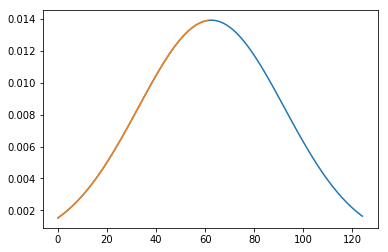

In [8]:
def gaussian(x, mu, sig):
    h = np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    h=h/np.sum(h)
    return h

def gaussian_kernel(window_size, mu, sig):
    window_vals = np.linspace(-(window_size)/2, (window_size)/2, window_size)
    window = gaussian(window_vals, mu, sig)
    return window

def half_gaussian_kernel(window_size, mu, sig):
    window_vals = np.linspace(-(window_size)/2, (window_size)/2, window_size)
    window = gaussian(window_vals, mu, sig)
    return window[0:len(window)/2]

plt.plot(gaussian_kernel(125, 0, 30))
plt.plot(half_gaussian_kernel(125, 0, 30))

In [9]:
all_tail_speed_filtered = []
g_kern = gaussian_kernel(125, 0, 30)
for row in all_tail_speed:
    row_filt = jump_stitcher_anyMetric(row, 0)
    row_filt = smoothen(row_filt, g_kern)
    all_tail_speed_filtered.append(row_filt)

all_tail_speed_filtered = np.asarray(all_tail_speed_filtered)
mean_tail_speed_filtered = np.nanmean(all_tail_speed_filtered, axis=0)

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


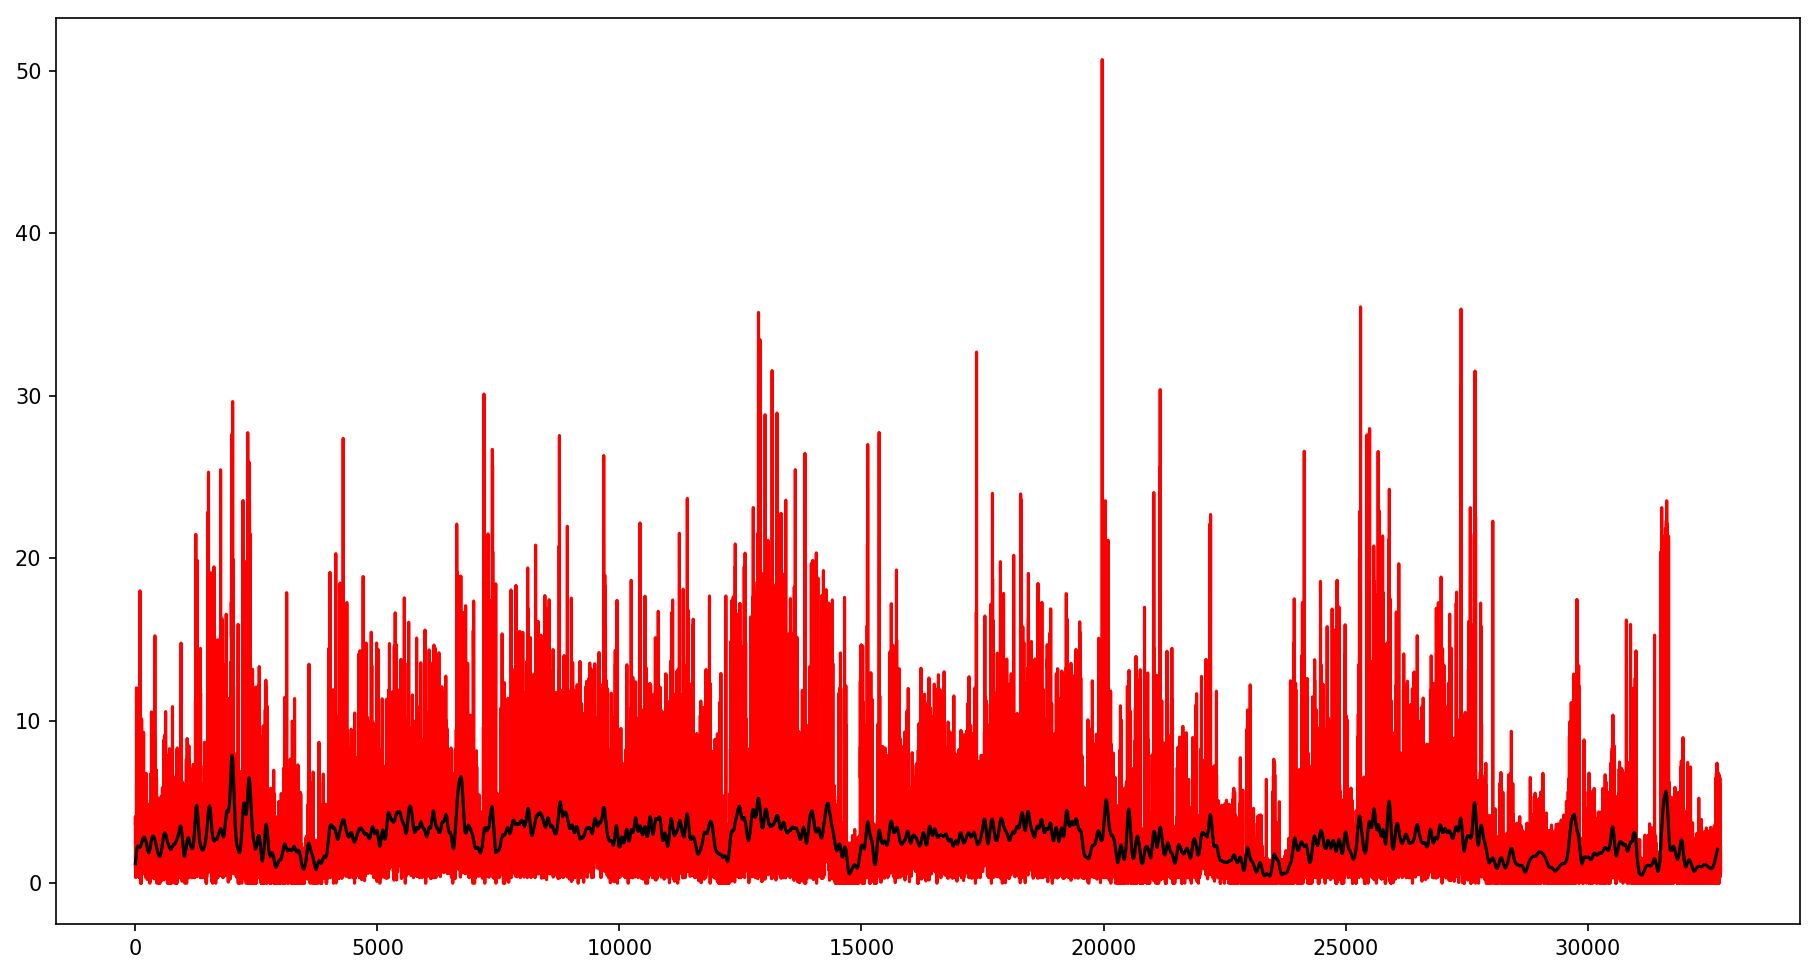

In [11]:
fig = plt.figure(figsize=(15,8), dpi=150)
plt.plot(all_tail_speed[0, :], 'r')
plt.plot(all_tail_speed_filtered[0, :], 'k')

In [10]:
from bokeh.models import Range1d
p1 = figure(x_axis_type="linear", title="Mean Tail Speed", plot_width=1200, plot_height=600)
p1.grid.grid_line_alpha=0.3
# Setting the second y axis range name and range
p1.extra_y_ranges = {"Stimulus": Range1d(start=0, end=50)}

# Adding the second axis to the plot.  
# p1.add_layout(LinearAxis(y_range_name="Stimulus (W/m^2)"), 'right')

p1.xaxis.axis_label = 'Time (sec)'
p1.yaxis.axis_label = 'Tail speed (mm/sec)'
p1.line(total_time, mean_tail_speed_filtered, legend='mean tail speed', color='navy')
p1.line(total_time, stimulus, legend='stimulus', color='red')
p1.legend.location = "top_left"

output_file("mean_tail_speed.html", title="meanTailSpeed")
show(p1)  # open a browser

# Setting the rect glyph params for the first graph. 
# Using the default y range and y axis here.           
# s1.rect(df_j.timestamp, mids, w, spans, fill_color="#D5E1DD", line_color="black")

# Setting the rect glyph params for the second graph.
# Using the aditional y range named "foo" and "right" y axis here. 
# s1.rect(df_j.timestamp, ad_bar_coord, w, bar_span, fill_color="#D5E1DD", color="green", y_range_name="foo")

In [ ]:
from bokeh.models import Range1d

def createGraph(tm, ts, stim):
    p = figure(x_axis_type="linear", title="Mean Tail Speed", plot_width=1200, plot_height=200)
#     p.grid.grid_line_alpha=0.3
#     p.xaxis.axis_label = 'Time (sec)'
#     p.yaxis.axis_label = 'Tail speed (mm/sec)'
    p.line(tm, ts, legend='mean tail speed', color='navy')
    p.line(tm, stim, legend='stimulus', color='red')
#     p.x_range=Range1d(left, right)
    p.y_range=Range1d(0, 10)
#     p.legend.location = "top_left"
    return p

all_plots = []
for tail_speed in all_tail_speed_filtered:
    tmp = createGraph(total_time, tail_speed, stimulus)
    all_plots.append(tmp)

output_file("indv_tail_speed.html", title="indvTailSpeed")

show(column(all_plots))  # open a browser

In [ ]:
for row in all_tail_speed:
    row_filt = jump_stitcher_anyMetric(row, 1)

#     row_filt = smoothen(row_filt, window)
#     all_tail_speed_filtered.append(row_filt)